In [ ]:
!pip install "tensorflow>=2.0.0"
!pip install --upgrade tensorflow-hub

In [ ]:
# TensorFlow Libraries
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Generic
import os
import random

In [ ]:
# Random Images Directory Path
random_images = '/content/drive/MyDrive/input/object-detection-sample-images/'

In [ ]:
# Function to Draw Bounding Boxes on Image
def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color,font,thickness=4,display_str_list=()):

    # Adds a bounding box to an image.
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],width=thickness,fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # display_str_heights = [font.getlength(ds)[1] for ds in display_str_list]
        # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (5 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),(left + text_width, text_bottom)],fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin


# Function to Draw Boxes
def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.1):

    # Overlay labeled boxes on an image with formatted scores and label names.
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

# Function to Draw Bounding Boxes on Image








In [ ]:
# Function to Display Image
def display_image(image,file):
    fig = plt.figure(figsize=(15, 10))
    plt.grid(False)
    plt.imshow(image)
    plt.title(file, fontsize=20)


# Function to Resize Image
def resize_image(img, new_width=300, new_height=300,display=False):
    img_path = os.path.join(random_images,img)
    pil_image = Image.open(img_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    if display:
        display_image(pil_image, img)

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


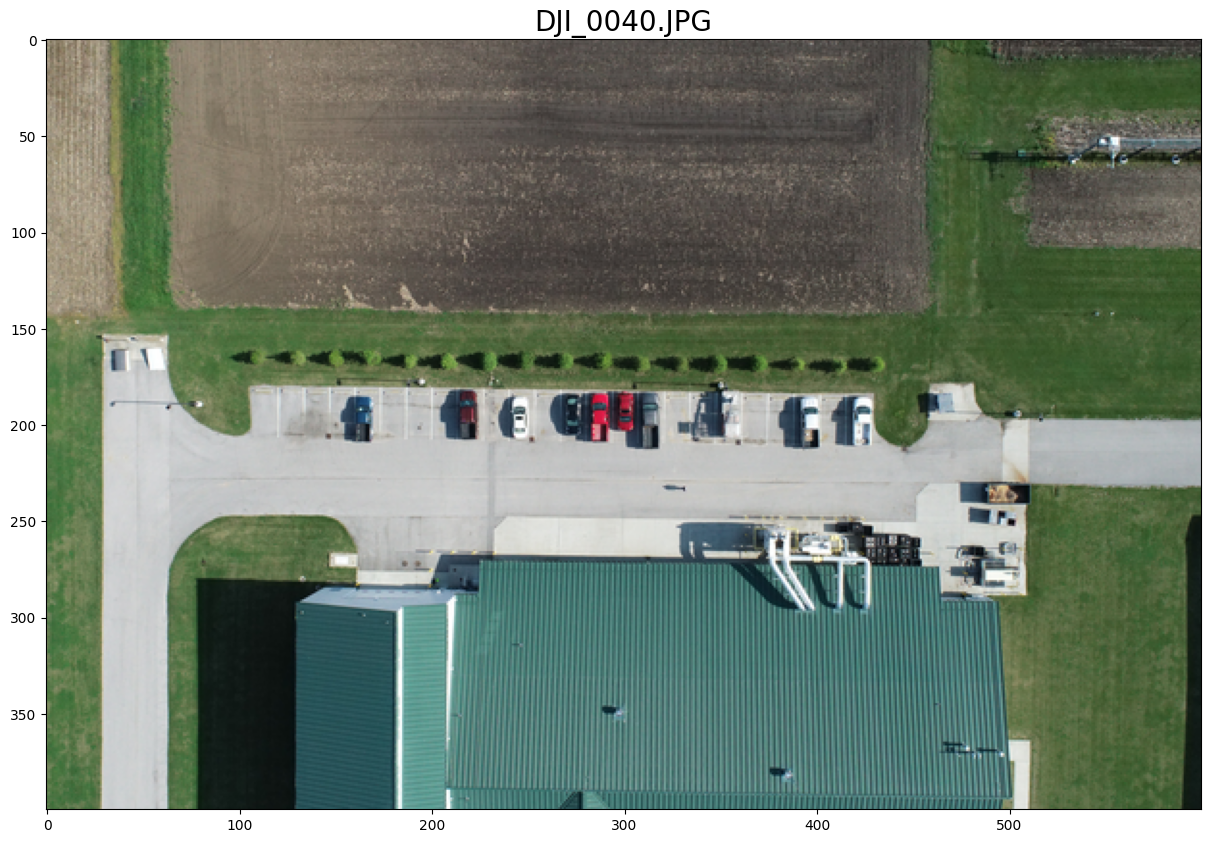

In [ ]:
# Applying the Function
import random
resize_image(random.choice(os.listdir(random_images)),600,400,True)

In [ ]:
import tensorflow_hub as hub
# FasterRCNN + InceptionResNet v2 Path
model_path = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# Define Model
PreTrained_Model = hub.load(model_path).signatures['default']

In [ ]:
# Function to Load Image from Random Image Folder using TensorFlow
def load_img(img_file):
    path = os.path.join(random_images,img_file)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [ ]:
# Function to Detect Object using TensorFlow's Pretrained Model
def detect(model, img_file):

    img = load_img(img_file)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    start_time = time.time()   # Start Timer

    result = model(converted_img)   # Detection Using Pretrained Model downloaded above

    end_time = time.time()    # End Timer

    result = {key:value.numpy() for key,value in result.items()}
    print(result.items)

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time (secs): ",'{:.2}'.format(end_time-start_time))

    image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"],result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes,img_file)


<built-in method items of dict object at 0x7f2d972306c0>
Found 100 objects.
Inference time (secs):  4.1e+01


<ipython-input-38-b98c17c45436>:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-38-b98c17c45436>:25: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


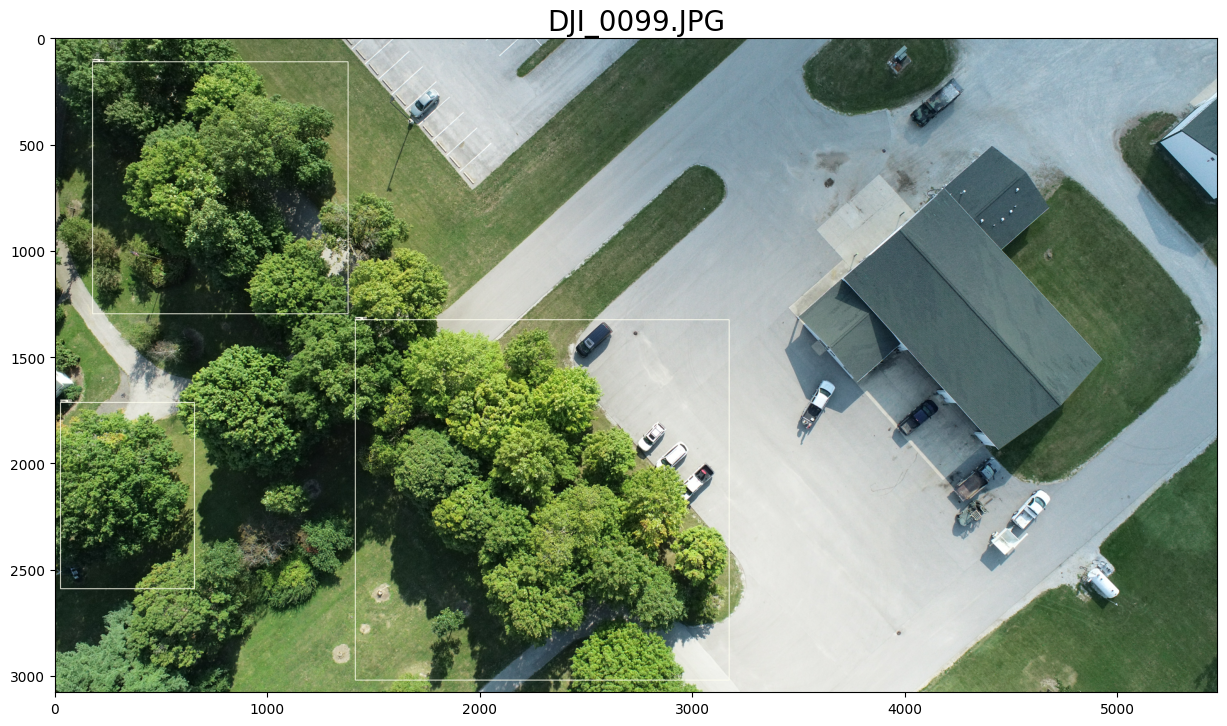

In [ ]:
# Running the Detect Function
detect(PreTrained_Model, random.choice(os.listdir(random_images)))